In [1]:
import tensorflow as tf

# Define the directory containing the images
directory = 'dataset'

# Specify the class names
class_names = ['Bacterialblight', 'Blast', 'Brownspot',"Healthy","Tungro"]
num_classes = tf.io.gfile.listdir(directory)
# Create a dataset using the images in the directory
train,test = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=16,
    image_size=(64, 64),
    shuffle=True,
    seed=42,
    validation_split=0.3,
    subset='both',
    class_names=class_names
)


Found 8164 files belonging to 5 classes.
Using 5715 files for training.
Using 2449 files for validation.


In [2]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, UpSampling2D, 
    Concatenate, Input, Dense, GlobalAveragePooling2D, 
    GlobalMaxPooling2D, BatchNormalization, Activation, 
    Add, Multiply, Reshape, Dropout
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def channel_attention_block(input_layer):

    avg_pool = GlobalAveragePooling2D()(input_layer)
    max_pool = GlobalMaxPooling2D()(input_layer)
    
    # Shared MLP for channel attention
    channels = input_layer.shape[-1]
    avg_dense = Dense(channels // 8, activation='relu')(avg_pool)
    avg_dense = Dense(channels, activation='sigmoid')(avg_dense)
    max_dense = Dense(channels // 8, activation='relu')(max_pool)
    max_dense = Dense(channels, activation='sigmoid')(max_dense)
    
    # Combine and reshape channel weights
    scale = Add()([avg_dense, max_dense])
    scale = Reshape((1, 1, channels))(scale)
    
    # Apply channel-wise attention
    return Multiply()([input_layer, scale])

def spatial_attention_block(input_layer):

    # Combine spatial context
    avg_pool = tf.reduce_mean(input_layer, axis=-1, keepdims=True)
    max_pool = tf.reduce_max(input_layer, axis=-1, keepdims=True)
    
    # Concatenate and apply convolution
    concat = Concatenate(axis=-1)([avg_pool, max_pool])
    attention = Conv2D(1, (7, 7), padding='same', activation='sigmoid')(concat)
    
    # Apply spatial attention
    return Multiply()([input_layer, attention])

def unet_attention_model(input_shape=(64, 64, 3), num_classes=5):

    # Input layer
    inputs = Input(shape=input_shape)
    
    # Encoder (Downsampling Path)
    # First encoder block
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same', 
                   kernel_regularizer=l2(0.001))(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same', 
                   kernel_regularizer=l2(0.001))(conv1)
    conv1 = BatchNormalization()(conv1)
    
    # Apply attention mechanisms
    conv1 = channel_attention_block(conv1)
    conv1 = spatial_attention_block(conv1)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = Dropout(0.3)(pool1)
    
    # Second encoder block
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same', 
                   kernel_regularizer=l2(0.001))(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same', 
                   kernel_regularizer=l2(0.001))(conv2)
    conv2 = BatchNormalization()(conv2)
    
    # Apply attention mechanisms
    conv2 = channel_attention_block(conv2)
    conv2 = spatial_attention_block(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = Dropout(0.4)(pool2)
    
    # Third encoder block
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same', 
                   kernel_regularizer=l2(0.001))(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same', 
                   kernel_regularizer=l2(0.001))(conv3)
    conv3 = BatchNormalization()(conv3)
    
    # Apply attention mechanisms
    conv3 = channel_attention_block(conv3)
    conv3 = spatial_attention_block(conv3)
    
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)
    
    # Bridge (Bottleneck)
    bridge = Conv2D(512, (3, 3), activation='relu', padding='same', 
                    kernel_regularizer=l2(0.001))(pool3)
    bridge = BatchNormalization()(bridge)
    bridge = Conv2D(512, (3, 3), activation='relu', padding='same', 
                    kernel_regularizer=l2(0.001))(bridge)
    bridge = BatchNormalization()(bridge)
    
    # Decoder (Upsampling Path) with skip connections
    # First decoder block
    up1 = UpSampling2D(size=(2, 2))(bridge)
    up1 = Concatenate()([up1, conv3])
    up1 = Conv2D(256, (3, 3), activation='relu', padding='same', 
                 kernel_regularizer=l2(0.001))(up1)
    up1 = BatchNormalization()(up1)
    up1 = Conv2D(256, (3, 3), activation='relu', padding='same', 
                 kernel_regularizer=l2(0.001))(up1)
    up1 = BatchNormalization()(up1)
    
    # Second decoder block
    up2 = UpSampling2D(size=(2, 2))(up1)
    up2 = Concatenate()([up2, conv2])
    up2 = Conv2D(128, (3, 3), activation='relu', padding='same', 
                 kernel_regularizer=l2(0.001))(up2)
    up2 = BatchNormalization()(up2)
    up2 = Conv2D(128, (3, 3), activation='relu', padding='same', 
                 kernel_regularizer=l2(0.001))(up2)
    up2 = BatchNormalization()(up2)
    
    # Third decoder block
    up3 = UpSampling2D(size=(2, 2))(up2)
    up3 = Concatenate()([up3, conv1])
    up3 = Conv2D(64, (3, 3), activation='relu', padding='same', 
                 kernel_regularizer=l2(0.001))(up3)
    up3 = BatchNormalization()(up3)
    up3 = Conv2D(64, (3, 3), activation='relu', padding='same', 
                 kernel_regularizer=l2(0.001))(up3)
    up3 = BatchNormalization()(up3)
    
    # Global Average Pooling for classification
    global_pool = GlobalAveragePooling2D()(up3)
    
    # Fully connected layers with increased dropout and regularization
    fc1 = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(global_pool)
    fc1 = Dropout(0.6)(fc1)
    fc2 = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(fc1)
    fc2 = Dropout(0.6)(fc2)
    
    # Output layer
    outputs = Dense(num_classes, activation='softmax')(fc2)
    
    # Create and compile model
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

def create_data_augmentation():

    return ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

def build_model(input_shape=(64, 64, 3), num_classes=5):

    # Create the model
    model = unet_attention_model(input_shape, num_classes)
    
    # Create callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss', 
        patience=10, 
        restore_best_weights=True
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.2, 
        patience=5, 
        min_lr=0.00001
    )
    
    return model, [early_stopping, reduce_lr]


In [3]:

# Load the model from the HDF5 file
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
import datetime
loaded_model,callbacks = build_model()

#loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Train the model with the TensorBoard callback
epochs = 30
history=loaded_model.fit(train,
          epochs=epochs,
          validation_data=test,
          callbacks=[tensorboard_callback])




Epoch 1/30
358/358 [==============================] - 3045s 8s/step - loss: 2.5992 - accuracy: 0.6012 - val_loss: 1.7521 - val_accuracy: 0.6570
Epoch 2/30
358/358 [==============================] - 3495s 10s/step - loss: 1.4047 - accuracy: 0.7151 - val_loss: 4.0736 - val_accuracy: 0.4696
Epoch 3/30
358/358 [==============================] - 3433s 10s/step - loss: 1.1628 - accuracy: 0.7454 - val_loss: 1.1171 - val_accuracy: 0.7395
Epoch 4/30
358/358 [==============================] - 3539s 10s/step - loss: 1.0404 - accuracy: 0.7668 - val_loss: 1.1349 - val_accuracy: 0.6974
Epoch 5/30
358/358 [==============================] - 3428s 10s/step - loss: 0.9341 - accuracy: 0.7883 - val_loss: 2.1090 - val_accuracy: 0.4831
Epoch 6/30
358/358 [==============================] - 3428s 10s/step - loss: 0.8643 - accuracy: 0.8072 - val_loss: 0.8698 - val_accuracy: 0.7873
Epoch 7/30
358/358 [==============================] - 3354s 9s/step - loss: 0.8158 - accuracy: 0.8135 - val_loss: 1.4362 - val_accu

In [4]:
loaded_model.save('my_model.h5')

In [5]:
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
model = load_model('my_model.h5')
loss, accuracy = model.evaluate(test)

# Print the accuracy
print(f'Test accuracy: {accuracy*100:.2f}%')


154/154 [==============================] - 165s 903ms/step - loss: 0.5171 - accuracy: 0.8746
Test accuracy: 87.46%


In [6]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 64)   1792        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 64, 64)   36928       ['batch_normalization[0][0]']

                                                                                                  
 reshape_1 (Reshape)            (None, 1, 1, 128)    0           ['add_1[0][0]']                  
                                                                                                  
 multiply_2 (Multiply)          (None, 32, 32, 128)  0           ['batch_normalization_3[0][0]',  
                                                                  'reshape_1[0][0]']              
                                                                                                  
 tf.math.reduce_mean_1 (TFOpLam  (None, 32, 32, 1)   0           ['multiply_2[0][0]']             
 bda)                                                                                             
                                                                                                  
 tf.math.reduce_max_1 (TFOpLamb  (None, 32, 32, 1)   0           ['multiply_2[0][0]']             
 da)      

 rmalization)                                                                                     
                                                                                                  
 up_sampling2d (UpSampling2D)   (None, 16, 16, 512)  0           ['batch_normalization_7[0][0]']  
                                                                                                  
 concatenate_3 (Concatenate)    (None, 16, 16, 768)  0           ['up_sampling2d[0][0]',          
                                                                  'multiply_5[0][0]']             
                                                                                                  
 conv2d_11 (Conv2D)             (None, 16, 16, 256)  1769728     ['concatenate_3[0][0]']          
                                                                                                  
 batch_normalization_8 (BatchNo  (None, 16, 16, 256)  1024       ['conv2d_11[0][0]']              
 rmalizati

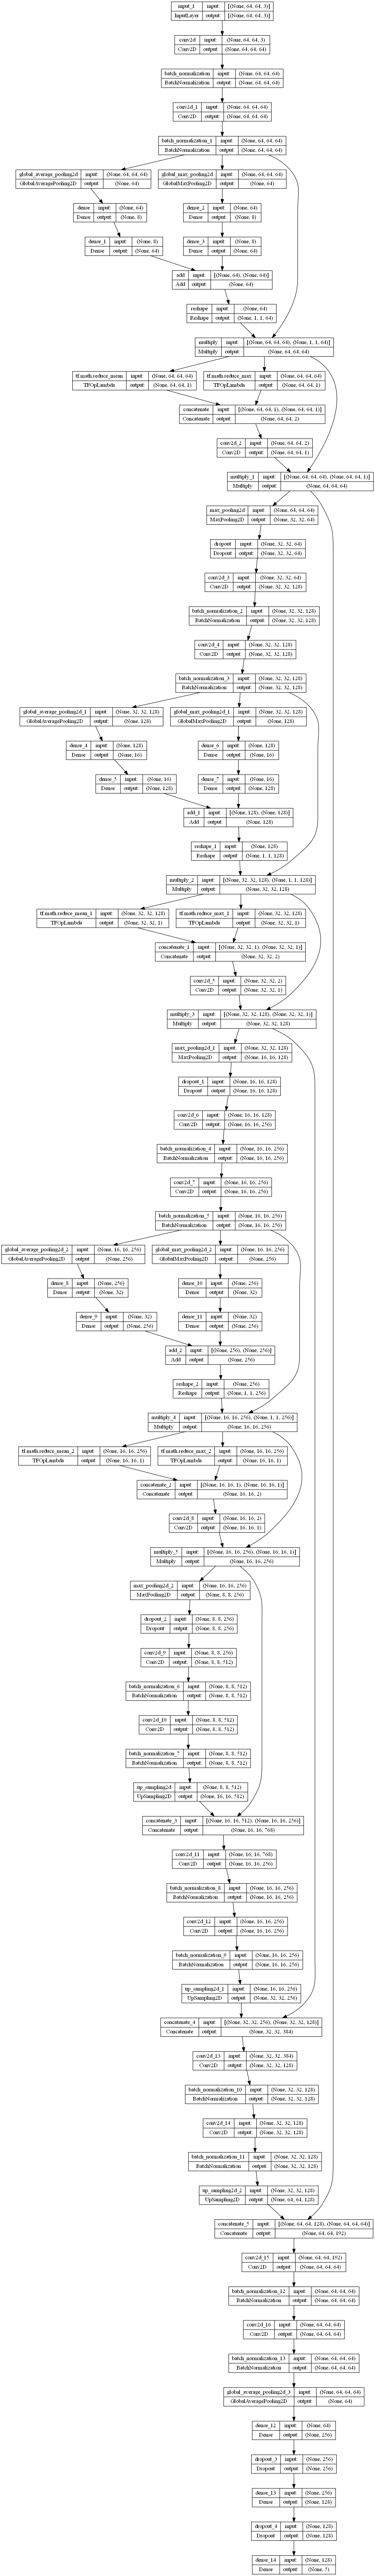

In [7]:
from tensorflow.keras.utils import plot_model

# Assuming `model` is your Keras model
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)
